# BAGGING

Bagging is basically bootstrap aggregation. It is a technique for reducing the variance by training multiple models on different samples of the training dataset. The final prediction is the average of the predictions of all the models.

---
## Import modules

In [10]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingRegressor

# others
from mltools import model_tools as MT

---
### 1.1 Load the data

In [7]:
# Load file with the dataset
df = pd.read_csv('./data/dataset_final.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
print('Dataframe:')
print(df.head())

Dataframe:
                 FECHA      UTIL      IRRAD  ANNO  DIA  DIASEM  MES  TRAMO
0  2015-01-01 00:00:00  0.000003        0.0  2015    1       3    1      0
1  2015-01-01 03:00:00  0.000006        0.0  2015    1       3    1      3
2  2015-01-01 06:00:00  0.067728        0.0  2015    1       3    1      6
3  2015-01-01 09:00:00  0.611120   760335.4  2015    1       3    1      9
4  2015-01-01 12:00:00  0.660956  1565422.5  2015    1       3    1     12


#### 1.2 Split the dataset in TR and TS

In [8]:
# Define input and output matrices
INPUTS = ['FECHA', 'IRRAD','ANNO', 'DIA', 'DIASEM', 'MES', 'TRAMO']
OUTPUT = 'UTIL'
X = df[INPUTS]
y = df[OUTPUT]

# Normalmente en series temporales tendriamos que hacer una division secuencial
# sin embargo, como aqui tenemos variables que categorizan el dia, mes y año no es necesario
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0) #seed for replication

### 1.4 Fit **single classification tree** (for comparison)

In [11]:
## Inputs of the model
INPUTS_DT = ['IRRAD','ANNO', 'DIA', 'DIASEM', 'MES', 'TRAMO']

# grid in min_impurity x min_samples_leaf x min_samples_split
param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005), # Minimum entropy to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

# param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split

pipe = Pipeline(steps=[('DT', DecisionTreeRegressor(criterion='squared_error',  # impurity measure
                                                     random_state=150))]) # For replication
                                                     
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('DT',
                                        DecisionTreeRegressor(random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [12]:
# Show the best grid parameter combination found by CV
tree_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 7,
 'min_samples_split': 1,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 150,
 'splitter': 'best'}

##### 1.4.1 Plot the single classification tree

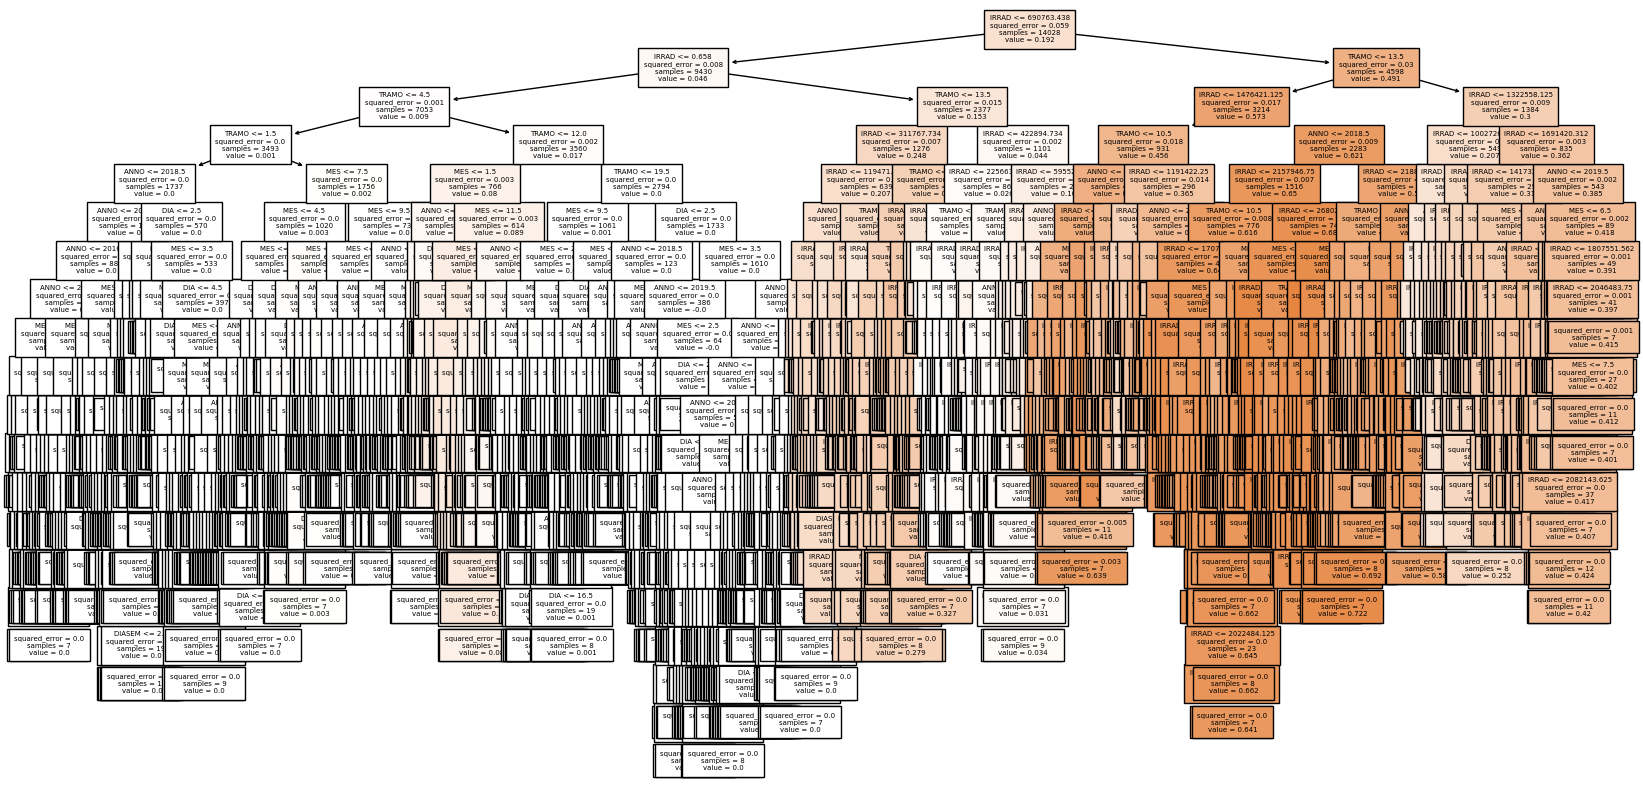

In [13]:
## Plot the decision tree model (use figsize and fontsize for getting the best view)
plt.figure(figsize=(20, 10))
plot_tree(tree_fit.best_estimator_['DT'],
          feature_names= INPUTS_DT,
          class_names= [str(s) for s in y_train.unique()],
          fontsize=5, filled=True)
plt.show()

##### 1.4.2 Compute errors of the single classification tree

In [14]:
SRT_TR_X  = X_train
SRT_TST_X = X_test

In [15]:
##  Compute errors
DT_reg_estim= tree_fit.best_estimator_['DT']

print('Single Regression Tree')
y_train_est_DT =  DT_reg_estim.predict(X_train[INPUTS_DT])
y_test_est_DT =  DT_reg_estim.predict(X_test[INPUTS_DT])

SRT_TR_X['UTIL'] = y_train
SRT_TR_X['UTIL_PRED_DT'] = y_train_est_DT
SRT_TST_X['UTIL'] = y_test
SRT_TST_X['UTIL_PRED_DT'] = y_test_est_DT

mse_tr_DT = np.mean((y_train - y_train_est_DT)**2)
mse_ts_DT = np.mean((y_test - y_test_est_DT)**2)

mae_tr_DT = np.mean(np.abs(y_train - y_train_est_DT))
mae_ts_DT  = np.mean(np.abs(y_test - y_test_est_DT))

r2_squared_tr_DT = metrics.r2_score(y_train, y_train_est_DT)
r2_squared_ts_DT = metrics.r2_score(y_test, y_test_est_DT)

print(f'MSE(TR) = {mse_tr_DT}')
print(f'MSE(TS) = {mse_ts_DT}')

print(f'MAE(TR) = {mae_tr_DT}')
print(f'MAE(TS) = {mae_ts_DT}')

print(f"R-squared(TR): {r2_squared_tr_DT}")
print(f"R-squared(TS): {r2_squared_ts_DT}")

Single Regression Tree
MSE(TR) = 0.0007202704344823445
MSE(TS) = 0.0012530498590069424
MAE(TR) = 0.013230576847976454
MAE(TS) = 0.017689042213420048
R-squared(TR): 0.9878440008703913
R-squared(TS): 0.9791744031318315


##### 1.4.3 Importances of the inputs in the single tree

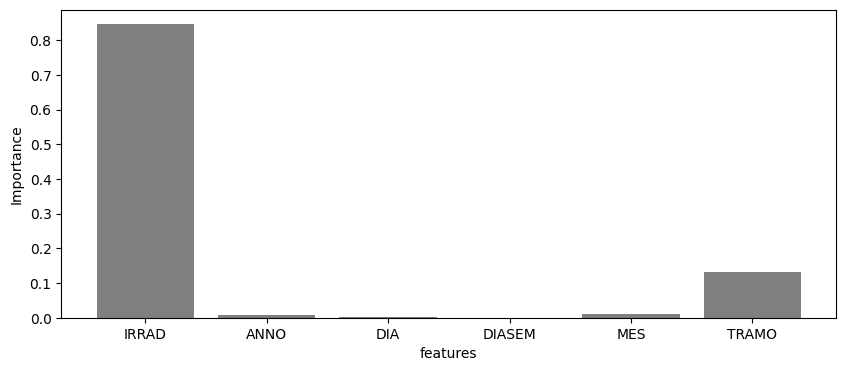

In [16]:
## Plot the variable importance of each feature
plt.figure(figsize=(10, 4))
bar_width = 0.35
plt.bar(INPUTS_DT, tree_fit.best_estimator_['DT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('features')
plt.ylabel('Importance')
plt.show()

### 1.5 Fit Bagged tree

##### 1.5.1 First straightforward version (without optim hyperparameters)

In [19]:
number_estimators = 50
base_estimator =  Pipeline(steps=[('DT', 
                                    DecisionTreeRegressor( criterion='squared_error',  # impurity measure
                                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                                            min_samples_leaf=1, # Minimum number of obs in a terminal node
                                                            random_state=999))]) # For replication


bag_reg_estim = BaggingRegressor(estimator=base_estimator,
                                    n_estimators=number_estimators,
                                    random_state=0)
                     
# fit the bagged trees
INPUTS_BT = INPUTS_DT                 
bag_reg_estim.fit(X_train[INPUTS_BT], y_train)

BaggingRegressor(estimator=Pipeline(steps=[('DT',
                                            DecisionTreeRegressor(random_state=999))]),
                 n_estimators=50, random_state=0)

In [21]:
##  Compute errors
print('Bagging Regression Tree')
y_train_est_BT =  bag_reg_estim.predict(X_train[INPUTS_DT])
y_test_est_BT =  bag_reg_estim.predict(X_test[INPUTS_DT])

SRT_TR_X['UTIL'] = y_train
SRT_TR_X['UTIL_PRED_BT'] = y_train_est_BT
SRT_TST_X['UTIL'] = y_test
SRT_TST_X['UTIL_PRED_BT'] = y_test_est_BT

mse_tr_BT = np.mean((y_train - y_train_est_BT)**2)
mse_ts_BT = np.mean((y_test - y_test_est_BT)**2)

mae_tr_BT = np.mean(np.abs(y_train - y_train_est_BT))
mae_ts_BT  = np.mean(np.abs(y_test - y_test_est_BT))

r2_squared_tr_BT = metrics.r2_score(y_train, y_train_est_BT)
r2_squared_ts_BT = metrics.r2_score(y_test, y_test_est_BT)

print(f'MSE(TR) = {mse_tr_BT}')
print(f'MSE(TS) = {mse_ts_BT}')

print(f'MAE(TR) = {mae_tr_BT}')
print(f'MAE(TS) = {mae_ts_BT}')

print(f"R-squared(TR): {r2_squared_tr_BT}")
print(f"R-squared(TS): {r2_squared_ts_BT}")

Bagging Regression Tree
MSE(TR) = 0.00014917768267676412
MSE(TS) = 0.0009989468597614464
MAE(TR) = 0.00593292393814351
MAE(TS) = 0.01570294000772258
R-squared(TR): 0.9974823292836127
R-squared(TS): 0.9833975763657147


##### 1.5.2 Feature importance evaluation in bagging using "Permutation Importance"

The permutation importance of a feature is calculated as follows:
- First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. 
- Next, a feature column from the validation set is permuted and the metric is evaluated again. 
- The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

For further reading see L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.

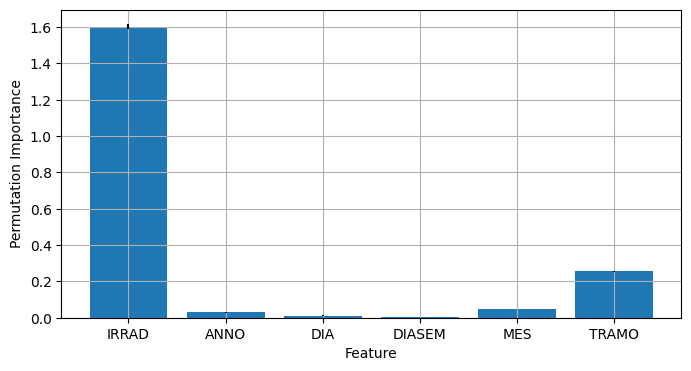

In [23]:
importances_reg_class_estim = permutation_importance(bag_reg_estim, 
                                    X_train[INPUTS_DT], y_train,
                                    n_repeats=10,
                                    random_state=0)

fig = plt.figure(2, figsize=(8, 4)) 
plt.bar(INPUTS_DT, importances_reg_class_estim.importances_mean, yerr=importances_reg_class_estim.importances_std)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.grid()
plt.show()

#### 1.5.4 Variability in the ensemble

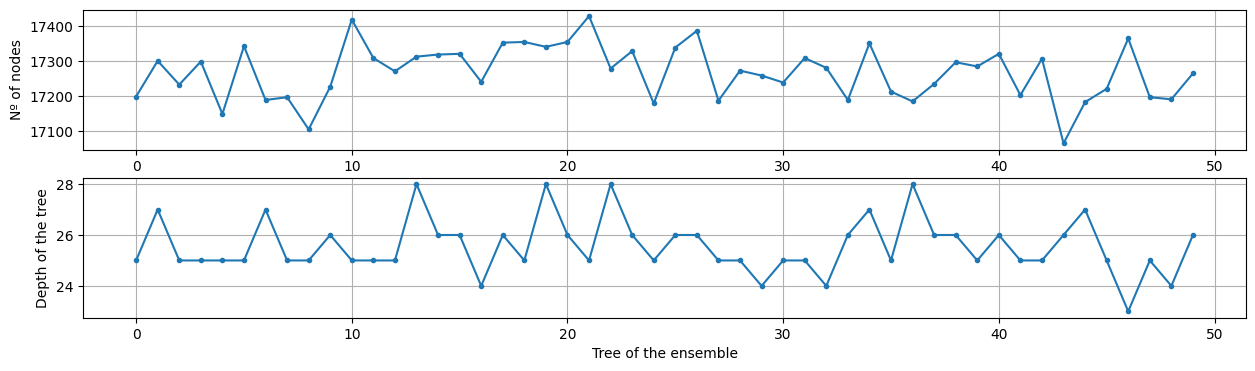

In [24]:
# number of nodes in each tree of the ensemble
node_count_trees = [t['DT'].tree_.node_count for t in bag_reg_estim.estimators_]

# number of nodes in each tree of the ensemble
depth_trees = [t['DT'].tree_.max_depth for t in bag_reg_estim.estimators_]

fig = plt.figure(1, figsize=(15, 4))
ax1=plt.subplot(2,1,1)
plt.plot(node_count_trees, '.-')
plt.ylabel('Nº of nodes')                       
plt.grid()

plt.subplot(2,1,2, sharex = ax1)
plt.plot(depth_trees, '.-')
plt.ylabel('Depth of the tree')                       
plt.xlabel('Tree of the ensemble')                  
plt.grid()
plt.show()

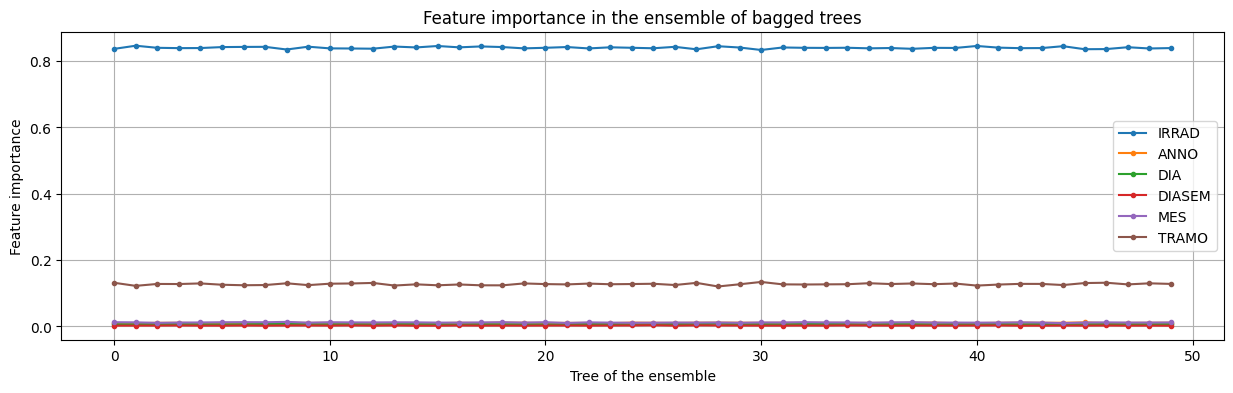

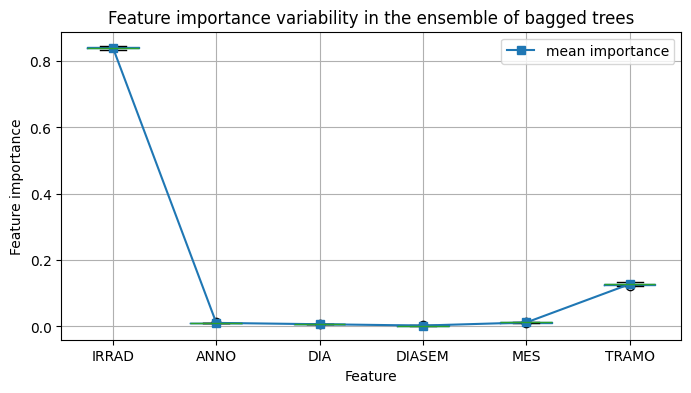

In [25]:
# feature importances of each tree in the ensemble
feature_importances_trees = [t['DT'].feature_importances_ for t in bag_reg_estim.estimators_]

fig = plt.figure(1, figsize=(15, 4))
plt.plot(feature_importances_trees, '.-', label = INPUTS_BT)
plt.ylabel('Feature importance') 
plt.xlabel('Tree of the ensemble')                                 
plt.title('Feature importance in the ensemble of bagged trees')
plt.grid()
plt.legend()
plt.show()

# global view of feature importances
dfimp =  pd.DataFrame(list(feature_importances_trees), columns=INPUTS_BT)
dfimp.boxplot(figsize=(8, 4))
plt.plot(np.arange(len(INPUTS_BT))+1, dfimp.mean(),'s-', label ='mean importance')
plt.ylabel('Feature importance') 
plt.xlabel('Feature') 
plt.title('Feature importance variability in the ensemble of bagged trees')
plt.legend()
plt.show()

### 1.6 Fit optimal classification bagged tree using Grid Search

In [26]:
# find optim nº of trees in the ensemble
param = {'BT__n_estimators': range(20, 150, 5)} # Number of trees to aggregate

pipe =  Pipeline(steps=[('BT', 
                            BaggingRegressor(estimator=base_estimator,
                                              random_state=150))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
bt_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_BT = INPUTS_DT
bt_fit.fit(X_train[INPUTS_BT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('BT',
                                        BaggingRegressor(estimator=Pipeline(steps=[('DT',
                                                                                    DecisionTreeRegressor(random_state=999))]),
                                                         random_state=150))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(20, 150, 5)})

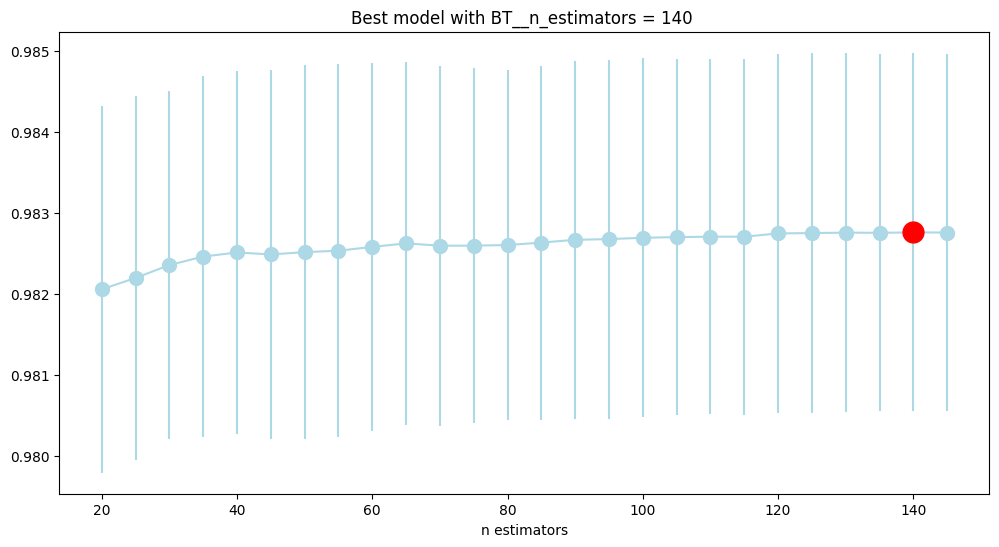

In [27]:
MT.plotModelGridError(bt_fit)

In [28]:
##  Compute errors
print('Optimal Bagging Regression Tree')
y_train_est_BTfit =  bt_fit.predict(X_train[INPUTS_DT])
y_test_est_BTfit =  bt_fit.predict(X_test[INPUTS_DT])

SRT_TR_X['UTIL'] = y_train
SRT_TR_X['UTIL_PRED_BTfit'] = y_train_est_BTfit
SRT_TST_X['UTIL'] = y_test
SRT_TST_X['UTIL_PRED_BTfit'] = y_test_est_BTfit

mse_tr_BTfit = np.mean((y_train - y_train_est_BTfit)**2)
mse_ts_BTfit = np.mean((y_test - y_test_est_BTfit)**2)

mae_tr_BTfit = np.mean(np.abs(y_train - y_train_est_BTfit))
mae_ts_BTfit  = np.mean(np.abs(y_test - y_test_est_BTfit))

r2_squared_tr_BTfit = metrics.r2_score(y_train, y_train_est_BTfit)
r2_squared_ts_BTfit = metrics.r2_score(y_test, y_test_est_BTfit)

print(f'MSE(TR) = {mse_tr_BTfit}')
print(f'MSE(TS) = {mse_ts_BTfit}')

print(f'MAE(TR) = {mae_tr_BTfit}')
print(f'MAE(TS) = {mae_ts_BTfit}')

print(f"R-squared(TR): {r2_squared_tr_BTfit}")
print(f"R-squared(TS): {r2_squared_ts_BTfit}")

Optimal Bagging Regression Tree
MSE(TR) = 0.00013833608438444884
MSE(TS) = 0.0009874912961494035
MAE(TR) = 0.005757843107546516
MAE(TS) = 0.015573876823497182
R-squared(TR): 0.9976653028628346
R-squared(TS): 0.9835879669938028
